# Chatbot Question-Answering Bahasa Indonesia dengan LSTM

## Deskripsi Project
Notebook ini membangun chatbot Question-Answering berbahasa Indonesia menggunakan **Long Short-Term Memory (LSTM)**.

### Dataset: IndoQA
- **Sumber**: Jakarta Artificial Intelligence Research
- **Jenis**: Question-Answering dataset monolingual bahasa Indonesia
- **Jumlah**: 4,413 contoh (training & validation)
- **Format**: Context paragraph + Question + Answer (extractive)

### Arsitektur Model
- **LSTM Encoder**: Untuk memproses context dan question dengan memory cells
- **Gates**: Forget, Input, dan Output gates untuk mengatur aliran informasi
- **Output Layer**: Prediksi posisi start dan end dari jawaban

---

## 1. Import Libraries

Import semua library yang diperlukan untuk preprocessing, modeling, dan evaluasi.

In [1]:
# Import library untuk data processing
import json  # untuk baca file JSON yang berisi dataset
import numpy as np  # untuk operasi array dan numerik
import pandas as pd  # untuk analisis data dalam bentuk tabel/dataframe
import re  # untuk regular expression (text processing)
from collections import Counter  # untuk menghitung frekuensi kata
import pickle  # untuk menyimpan objek python ke file
import os  # untuk operasi file system

# Import library Deep Learning dari TensorFlow/Keras
import tensorflow as tf  # framework deep learning utama
from tensorflow import keras  # API high-level untuk bikin model
from tensorflow.keras.models import Model  # untuk bikin model custom
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout, Bidirectional  # layer-layer yang dipakai
from tensorflow.keras.preprocessing.text import Tokenizer  # untuk tokenisasi teks jadi angka
from tensorflow.keras.preprocessing.sequence import pad_sequences  # untuk padding sequences supaya sama panjang
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau  # callback untuk monitoring training
from tensorflow.keras.optimizers import Adam  # optimizer Adam untuk training

# Import library untuk visualisasi
import matplotlib.pyplot as plt  # untuk bikin plot grafik
import seaborn as sns  # untuk visualisasi yang lebih bagus

# Import utilities
from tqdm import tqdm  # untuk progress bar saat looping
import warnings  # untuk handle warning messages
warnings.filterwarnings('ignore')  # matikan warning biar output lebih bersih

# Set random seeds supaya hasil training bisa direproduksi
np.random.seed(42)  # seed untuk numpy random
tf.random.set_seed(42)  # seed untuk tensorflow random

# Cek versi TensorFlow dan ketersediaan GPU
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Load Dataset

Memuat dataset IndoQA dari file JSON yang telah didownload.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir -p /content/Dataset
!cp -r /content/drive/MyDrive/Dataset_ChatBot/* /content/Dataset/

In [4]:
# Definisikan path ke file dataset
TRAIN_PATH = 'Dataset/df_train.json'  # path untuk data training
VAL_PATH = 'Dataset/df_val.json'  # path untuk data validation

# Load data training dari file JSON
print("Loading training data...")
with open(TRAIN_PATH, 'r', encoding='utf-8') as f:  # buka file dengan encoding UTF-8 untuk bahasa Indonesia
    train_data = json.load(f)  # parse JSON jadi list of dictionary

# Load data validation dari file JSON
print("Loading validation data...")
with open(VAL_PATH, 'r', encoding='utf-8') as f:  # buka file dengan encoding UTF-8
    val_data = json.load(f)  # parse JSON jadi list of dictionary

# Tampilkan jumlah data yang berhasil dimuat
print(f"\nTotal Training Examples: {len(train_data)}")
print(f"Total Validation Examples: {len(val_data)}")

# Tampilkan contoh data pertama untuk melihat strukturnya
print("\nSample Training Data:")
print(f"ID: {train_data[0]['id']}")  # ID unik untuk setiap data
print(f"Question: {train_data[0]['question']}")  # pertanyaan yang diajukan
print(f"Answer: {train_data[0]['answer']}")  # jawaban yang benar
print(f"Context: {train_data[0]['context'][:200]}...")  # context (dipotong 200 karakter pertama)
print(f"Category: {train_data[0]['category']}")  # kategori dari data (SPAN, dll)

Loading training data...
Loading validation data...

Total Training Examples: 3309
Total Validation Examples: 1104

Sample Training Data:
ID: 629HsNl5Qf3THUq_CbmFrSx28
Question: Dengan siapa Chaerul Saleh, Sukarni, Wikana, dan para pemuda pejuang berdiskusi?
Answer: Ibrahim gelar Datuk Tan Malaka
Context: Para pemuda pejuang, termasuk Chaerul Saleh, Sukarni, dan Wikana yang terbakar gelora kepahlawanannya setelah berdiskusi dengan Ibrahim gelar Datuk Tan Malaka. Pada dini hari tanggal 16 Agustus 1945, ...
Category: SPAN


### 2.1 Dataset Quality Inspection

Mari kita inspect beberapa contoh data untuk memahami struktur dan kualitas dataset.

In [5]:
# Fungsi untuk inspect dan validasi contoh data
def inspect_dataset_sample(data, num_samples=3):
    """
    Inspect beberapa sample dari dataset dan verifikasi answer positions.
    """
    print("="*80)
    print("DATASET QUALITY INSPECTION")
    print("="*80)

    for i, item in enumerate(data[:num_samples], 1):
        print(f"\n{'─'*80}")
        print(f"SAMPLE {i}:")
        print(f"{'─'*80}")

        context = item['context']
        question = item['question']
        answer = item.get('answer', None)
        span_start = item.get('span_start', None)
        span_end = item.get('span_end', None)

        print(f"\n📄 CONTEXT (first 200 chars):")
        print(f"{context[:200]}...")

        print(f"\n❓ QUESTION:")
        print(f"{question}")

        print(f"\n✅ ANSWER:")
        print(f"{answer}")

        # Handle None answer
        if answer is None or span_start == -1:
            print(f"\n⚠️  WARNING: Invalid data - answer is None or span_start=-1")
            print(f"   This sample should be SKIPPED during training")
            continue

        print(f"\n📍 POSITIONS IN DATASET:")
        print(f"   span_start: {span_start}")
        print(f"   span_end: {span_end}")

        # Verifikasi: Apakah ini character position atau word position?
        if span_start is not None and span_end is not None:
            # Coba extract dengan character position
            extracted_char = context[span_start:span_end]

            # Coba extract dengan word position
            context_words = context.split()
            if span_end < len(context_words):
                extracted_word = ' '.join(context_words[span_start:span_end+1])
            else:
                extracted_word = "OUT OF BOUNDS"

            print(f"\n🔍 VERIFICATION:")
            print(f"   If CHARACTER position → '{extracted_char}'")
            print(f"   If WORD position → '{extracted_word}'")
            print(f"   Expected answer → '{answer}'")

            # Check which one matches
            if extracted_char.strip().lower() == answer.strip().lower():
                print(f"   ✅ Dataset uses CHARACTER POSITIONS")
            elif extracted_word.strip().lower() == answer.strip().lower():
                print(f"   ✅ Dataset uses WORD POSITIONS")
            else:
                print(f"   ⚠️  WARNING: Neither matches! Possible data quality issue")
                print(f"      Similarity char: {extracted_char.strip()[:50]}")
                print(f"      Similarity word: {extracted_word.strip()[:50]}")

        # Check answer ada di context atau tidak
        if answer.lower() in context.lower():
            print(f"   ✅ Answer found in context")
            # Find actual position
            char_pos = context.lower().find(answer.lower())
            print(f"   📍 Actual character position: {char_pos}")
        else:
            print(f"   ⚠️  WARNING: Answer NOT found in context (exact match)")

    print(f"\n{'='*80}")

# Inspect training data samples
print("Inspecting TRAINING data samples...\n")
inspect_dataset_sample(train_data, num_samples=3)

print("\n\n")

# Inspect validation data samples
print("Inspecting VALIDATION data samples...\n")
inspect_dataset_sample(val_data, num_samples=2)

Inspecting TRAINING data samples...

DATASET QUALITY INSPECTION

────────────────────────────────────────────────────────────────────────────────
SAMPLE 1:
────────────────────────────────────────────────────────────────────────────────

📄 CONTEXT (first 200 chars):
Para pemuda pejuang, termasuk Chaerul Saleh, Sukarni, dan Wikana yang terbakar gelora kepahlawanannya setelah berdiskusi dengan Ibrahim gelar Datuk Tan Malaka. Pada dini hari tanggal 16 Agustus 1945, ...

❓ QUESTION:
Dengan siapa Chaerul Saleh, Sukarni, Wikana, dan para pemuda pejuang berdiskusi?

✅ ANSWER:
Ibrahim gelar Datuk Tan Malaka

📍 POSITIONS IN DATASET:
   span_start: 128
   span_end: 158

🔍 VERIFICATION:
   If CHARACTER position → 'Ibrahim gelar Datuk Tan Malaka'
   If WORD position → 'OUT OF BOUNDS'
   Expected answer → 'Ibrahim gelar Datuk Tan Malaka'
   ✅ Dataset uses CHARACTER POSITIONS
   ✅ Answer found in context
   📍 Actual character position: 128

───────────────────────────────────────────────────────────

## 3. Exploratory Data Analysis (EDA)

Analisis dataset untuk memahami karakteristik data.

In [6]:
# Konversi data JSON jadi DataFrame supaya lebih mudah dianalisis
train_df = pd.DataFrame(train_data)  # bikin DataFrame dari list training data
val_df = pd.DataFrame(val_data)  # bikin DataFrame dari list validation data

# Tampilkan statistik dasar dari data training
print("TRAINING DATA STATISTICS")
print("="*50)
print(train_df.info())  # info tentang kolom, tipe data, dan missing values
print("\nCategory Distribution:")
print(train_df['category'].value_counts())  # hitung jumlah data per kategori

# Analisis panjang teks dalam kata
train_df['context_length'] = train_df['context'].apply(lambda x: len(x.split()))  # hitung jumlah kata di context
train_df['question_length'] = train_df['question'].apply(lambda x: len(x.split()))  # hitung jumlah kata di question
train_df['answer_length'] = train_df['answer'].apply(lambda x: len(str(x).split()) if x else 0)  # hitung jumlah kata di answer

# Tampilkan statistik panjang teks
print("\nLength Statistics (in words):")
print(f"Context - Mean: {train_df['context_length'].mean():.2f}, Max: {train_df['context_length'].max()}")  # rata-rata dan max panjang context
print(f"Question - Mean: {train_df['question_length'].mean():.2f}, Max: {train_df['question_length'].max()}")  # rata-rata dan max panjang question
print(f"Answer - Mean: {train_df['answer_length'].mean():.2f}, Max: {train_df['answer_length'].max()}")  # rata-rata dan max panjang answer

TRAINING DATA STATISTICS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3309 entries, 0 to 3308
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          3309 non-null   object
 1   context     3309 non-null   object
 2   question    3309 non-null   object
 3   answer      3250 non-null   object
 4   category    3309 non-null   object
 5   span_start  3309 non-null   int64 
 6   span_end    3309 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 181.1+ KB
None

Category Distribution:
category
SPAN            3189
UNANSWERABLE      60
YESNO             60
Name: count, dtype: int64

Length Statistics (in words):
Context - Mean: 84.75, Max: 149
Question - Mean: 7.90, Max: 20
Answer - Mean: 4.82, Max: 54


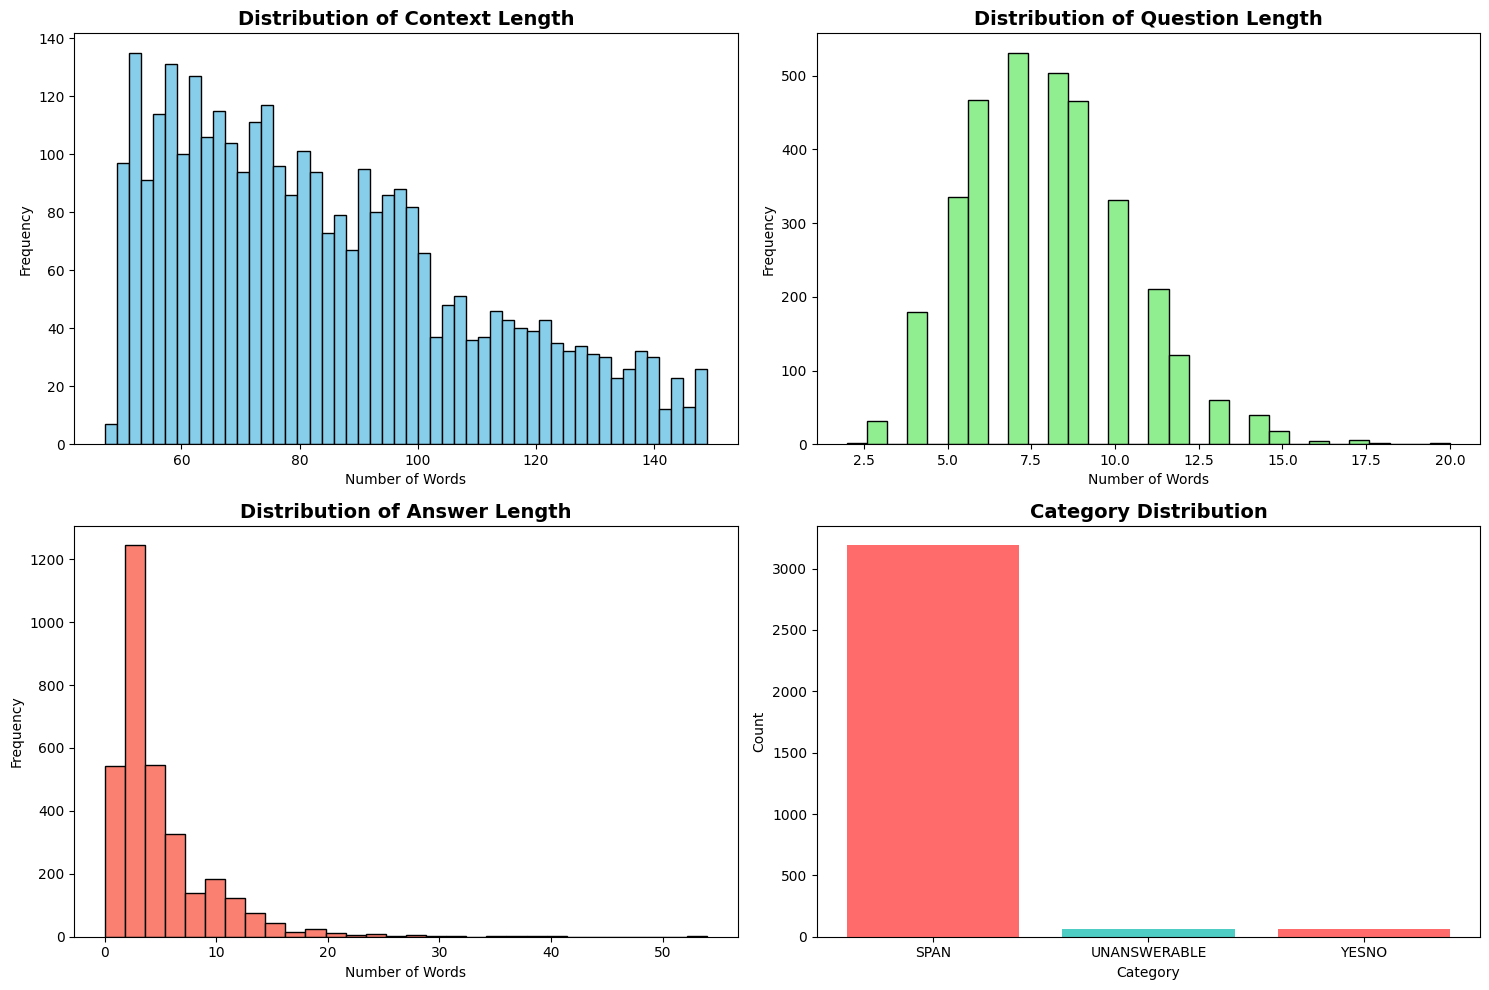

In [7]:
# Visualisasi distribusi panjang teks menggunakan histogram
fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # bikin 4 subplot dalam satu figure

# Histogram distribusi panjang context
axes[0, 0].hist(train_df['context_length'], bins=50, color='skyblue', edgecolor='black')  # bagi jadi 50 bins
axes[0, 0].set_title('Distribution of Context Length', fontsize=14, fontweight='bold')  # judul grafik
axes[0, 0].set_xlabel('Number of Words')  # label sumbu x
axes[0, 0].set_ylabel('Frequency')  # label sumbu y

# Histogram distribusi panjang question
axes[0, 1].hist(train_df['question_length'], bins=30, color='lightgreen', edgecolor='black')  # bagi jadi 30 bins
axes[0, 1].set_title('Distribution of Question Length', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Words')
axes[0, 1].set_ylabel('Frequency')

# Histogram distribusi panjang answer
axes[1, 0].hist(train_df['answer_length'], bins=30, color='salmon', edgecolor='black')  # bagi jadi 30 bins
axes[1, 0].set_title('Distribution of Answer Length', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Number of Words')
axes[1, 0].set_ylabel('Frequency')

# Bar chart distribusi kategori
category_counts = train_df['category'].value_counts()  # hitung jumlah per kategori
axes[1, 1].bar(category_counts.index, category_counts.values, color=['#FF6B6B', '#4ECDC4'])  # bikin bar chart dengan warna custom
axes[1, 1].set_title('Category Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Category')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()  # atur layout supaya tidak overlap
plt.show()  # tampilkan semua grafik

### 3.1 Analisis Statistik Dasar Dataset

Mari kita lihat informasi detail tentang dataset untuk memahami karakteristiknya.

In [8]:
# Analisis statistik lengkap untuk memahami dataset lebih dalam
print("="*70)
print("ANALISIS DATASET INDOQA")
print("="*70)

# 1. Tampilkan ukuran dataset
print(f"\n1. UKURAN DATASET")
print(f"   - Total training samples: {len(train_data):,}")  # format angka dengan koma pemisah ribuan
print(f"   - Total validation samples: {len(val_data):,}")
print(f"   - Total keseluruhan: {len(train_data) + len(val_data):,}")

# 2. Analisis distribusi kategori di training set
print(f"\n2. DISTRIBUSI KATEGORI")
print(f"   Training:")
for category, count in train_df['category'].value_counts().items():  # loop setiap kategori
    percentage = (count / len(train_df)) * 100  # hitung persentase
    print(f"   - {category}: {count:,} ({percentage:.2f}%)")

# Analisis distribusi kategori di validation set
print(f"\n   Validation:")
val_df = pd.DataFrame(val_data)  # konversi validation data ke DataFrame
for category, count in val_df['category'].value_counts().items():
    percentage = (count / len(val_df)) * 100
    print(f"   - {category}: {count:,} ({percentage:.2f}%)")

# 3. Statistik detail panjang context
print(f"\n3. STATISTIK PANJANG TEKS (dalam kata)")
print(f"   Context:")
print(f"   - Mean: {train_df['context_length'].mean():.2f}")  # rata-rata
print(f"   - Median: {train_df['context_length'].median():.0f}")  # nilai tengah
print(f"   - Std Dev: {train_df['context_length'].std():.2f}")  # standar deviasi
print(f"   - Min: {train_df['context_length'].min()}")  # nilai minimum
print(f"   - Max: {train_df['context_length'].max()}")  # nilai maksimum
print(f"   - Q1 (25%): {train_df['context_length'].quantile(0.25):.0f}")  # kuartil pertama
print(f"   - Q3 (75%): {train_df['context_length'].quantile(0.75):.0f}")  # kuartil ketiga

# Statistik detail panjang question
print(f"\n   Question:")
print(f"   - Mean: {train_df['question_length'].mean():.2f}")
print(f"   - Median: {train_df['question_length'].median():.0f}")
print(f"   - Std Dev: {train_df['question_length'].std():.2f}")
print(f"   - Min: {train_df['question_length'].min()}")
print(f"   - Max: {train_df['question_length'].max()}")

# Statistik detail panjang answer
print(f"\n   Answer:")
print(f"   - Mean: {train_df['answer_length'].mean():.2f}")
print(f"   - Median: {train_df['answer_length'].median():.0f}")
print(f"   - Std Dev: {train_df['answer_length'].std():.2f}")

ANALISIS DATASET INDOQA

1. UKURAN DATASET
   - Total training samples: 3,309
   - Total validation samples: 1,104
   - Total keseluruhan: 4,413

2. DISTRIBUSI KATEGORI
   Training:
   - SPAN: 3,189 (96.37%)
   - UNANSWERABLE: 60 (1.81%)
   - YESNO: 60 (1.81%)

   Validation:
   - SPAN: 1,064 (96.38%)
   - UNANSWERABLE: 20 (1.81%)
   - YESNO: 20 (1.81%)

3. STATISTIK PANJANG TEKS (dalam kata)
   Context:
   - Mean: 84.75
   - Median: 80
   - Std Dev: 25.11
   - Min: 47
   - Max: 149
   - Q1 (25%): 64
   - Q3 (75%): 101

   Question:
   - Mean: 7.90
   - Median: 8
   - Std Dev: 2.43
   - Min: 2
   - Max: 20

   Answer:
   - Mean: 4.82
   - Median: 3
   - Std Dev: 4.49


### 3.2 Analisis Sample Data

Mari kita lihat beberapa contoh data untuk memahami struktur dan kontennya.

In [9]:
# Tampilkan beberapa contoh data untuk melihat struktur dan isinya
print("="*80)
print("CONTOH DATA DARI DATASET")
print("="*80)

# Ambil 3 contoh pertama dari kategori SPAN
span_examples = train_df[train_df['category'] == 'SPAN'].head(3)  # filter hanya kategori SPAN, ambil 3 data
print("\n1. CONTOH KATEGORI SPAN (Extractive QA - Answer ada di dalam context)")
print("-"*80)

# Loop untuk tampilkan setiap contoh dengan detail
for idx, row in span_examples.iterrows():  # iterrows() untuk loop DataFrame by row
    print(f"\nContoh {idx + 1}:")
    print(f"ID: {row['id']}")
    print(f"\nContext ({row['context_length']} kata):")
    # Potong context kalau terlalu panjang (lebih dari 300 karakter)
    print(f"{row['context'][:300]}..." if len(row['context']) > 300 else row['context'])
    print(f"\nQuestion ({row['question_length']} kata): {row['question']}")
    print(f"\nAnswer ({row['answer_length']} kata): {row['answer']}")
    print("-"*80)

# Cek apakah ada kategori lain selain SPAN
if len(train_df['category'].unique()) > 1:
    # Ambil nama kategori selain SPAN
    other_category = [cat for cat in train_df['category'].unique() if cat != 'SPAN'][0]  # list comprehension
    other_examples = train_df[train_df['category'] == other_category].head(2)  # ambil 2 contoh
    print(f"\n2. CONTOH KATEGORI {other_category}")
    print("-"*80)

    # Loop untuk tampilkan contoh dari kategori lain
    for idx, row in other_examples.iterrows():
        print(f"\nContoh:")
        print(f"ID: {row['id']}")
        print(f"\nContext: {row['context'][:200]}...")  # potong 200 karakter pertama
        print(f"\nQuestion: {row['question']}")
        print(f"\nAnswer: {row['answer']}")
        print("-"*80)

print("\n" + "="*80)

CONTOH DATA DARI DATASET

1. CONTOH KATEGORI SPAN (Extractive QA - Answer ada di dalam context)
--------------------------------------------------------------------------------

Contoh 1:
ID: 629HsNl5Qf3THUq_CbmFrSx28

Context (91 kata):
Para pemuda pejuang, termasuk Chaerul Saleh, Sukarni, dan Wikana yang terbakar gelora kepahlawanannya setelah berdiskusi dengan Ibrahim gelar Datuk Tan Malaka. Pada dini hari tanggal 16 Agustus 1945, mereka bersama Shodanco Singgih, salah seorang anggota PETA, dan pemuda lain, membawa Soekarno (bers...

Question (11 kata): Dengan siapa Chaerul Saleh, Sukarni, Wikana, dan para pemuda pejuang berdiskusi?

Answer (5 kata): Ibrahim gelar Datuk Tan Malaka
--------------------------------------------------------------------------------

Contoh 2:
ID: 2648F832Z8D-thJnrxy_ZoZ11111

Context (68 kata):
Malaysia terdiri atas dua kawasan utama yang terpisah oleh Laut Tiongkok Selatan. Keduanya memiliki bentuk muka bumi yang hampir sama, yaitu dari pinggir laut yan

### 3.3 Analisis Kata dan Vocabulary

Analisis vocabulary dan kata-kata yang paling sering muncul dalam dataset.

In [10]:
# Analisis vocabulary dan kata-kata yang paling sering muncul
from collections import Counter  # import Counter untuk hitung frekuensi

# Kumpulkan semua kata dari context dan question
all_words = []  # list untuk tampung semua kata
for item in train_data:  # loop setiap data training
    if item.get('context'):  # cek apakah ada key 'context'
        all_words.extend(item['context'].lower().split())  # split jadi kata-kata, ubah ke lowercase
    if item.get('question'):  # cek apakah ada key 'question'
        all_words.extend(item['question'].lower().split())

# Hitung frekuensi setiap kata menggunakan Counter
word_freq = Counter(all_words)  # Counter otomatis hitung frekuensi setiap kata

print("="*70)
print("ANALISIS VOCABULARY")
print("="*70)

# Tampilkan statistik vocabulary
print(f"\nTotal kata (dengan duplikasi): {len(all_words):,}")  # total semua kata termasuk yang sama
print(f"Unique words (vocabulary size): {len(word_freq):,}")  # jumlah kata unik

# Tampilkan 20 kata paling sering muncul
print(f"\n20 Kata Paling Sering Muncul:")
print("-"*70)
for word, count in word_freq.most_common(20):  # most_common(n) untuk ambil n kata teratas
    percentage = (count / len(all_words)) * 100  # hitung persentase kemunculan
    print(f"{word:20s} : {count:6,} kali ({percentage:.2f}%)")  # format output dengan padding

# Analisis kata yang muncul di questions (pertanyaan)
question_words = []  # list untuk tampung kata-kata dari question
for item in train_data:
    if item.get('question'):
        question_words.extend(item['question'].lower().split())  # split dan lowercase

question_freq = Counter(question_words)  # hitung frekuensi kata di question

# Tampilkan 20 kata paling sering di question
print(f"\n\n20 Kata Paling Sering di QUESTION:")
print("-"*70)
for word, count in question_freq.most_common(20):
    percentage = (count / len(question_words)) * 100
    print(f"{word:20s} : {count:6,} kali ({percentage:.2f}%)")

# Analisis distribusi panjang kata
print(f"\n\nDISTRIBUSI PANJANG KATA:")
print("-"*70)
word_lengths = [len(word) for word in word_freq.keys()]  # list comprehension untuk ambil panjang setiap kata unik
print(f"Rata-rata panjang kata: {np.mean(word_lengths):.2f} karakter")  # hitung mean
print(f"Median panjang kata: {np.median(word_lengths):.0f} karakter")  # hitung median
print(f"Kata terpendek: {min(word_lengths)} karakter")  # cari panjang minimum
print(f"Kata terpanjang: {max(word_lengths)} karakter")  # cari panjang maksimum

print("\n" + "="*70)

ANALISIS VOCABULARY

Total kata (dengan duplikasi): 306,560
Unique words (vocabulary size): 23,180

20 Kata Paling Sering Muncul:
----------------------------------------------------------------------
dan                  :  9,200 kali (3.00%)
yang                 :  8,949 kali (2.92%)
di                   :  6,949 kali (2.27%)
pada                 :  5,138 kali (1.68%)
dari                 :  3,436 kali (1.12%)
dengan               :  3,260 kali (1.06%)
untuk                :  2,434 kali (0.79%)
dalam                :  2,361 kali (0.77%)
tahun                :  2,065 kali (0.67%)
sebagai              :  2,007 kali (0.65%)
oleh                 :  1,984 kali (0.65%)
ini                  :  1,826 kali (0.60%)
adalah               :  1,521 kali (0.50%)
indonesia            :  1,458 kali (0.48%)
menjadi              :  1,433 kali (0.47%)
ke                   :  1,325 kali (0.43%)
negara               :  1,212 kali (0.40%)
tidak                :  1,118 kali (0.36%)
juga                 :  1

## 4. Data Preprocessing

### 4.1 Text Cleaning
Membersihkan dan menormalisasi teks.

In [11]:
def clean_text(text):
    """
    Fungsi untuk membersihkan teks dari karakter khusus dan normalisasi format.
    """
    if not text:  # cek kalau text kosong/None
        return ""

    # Ubah semua huruf jadi lowercase (huruf kecil) supaya konsisten
    text = text.lower()

    # Hapus spasi berlebih (multiple whitespaces jadi satu spasi)
    text = ' '.join(text.split())  # split() hapus semua whitespace, join() gabung dengan satu spasi

    return text

# Filter data - hanya ambil kategori SPAN yang punya answer
print("Filtering and cleaning data...")
# List comprehension untuk filter data yang memenuhi kriteria
train_filtered = [item for item in train_data if item['category'] == 'SPAN' and item['answer']]
val_filtered = [item for item in val_data if item['category'] == 'SPAN' and item['answer']]

# Tampilkan hasil filtering
print(f"Filtered Training Examples: {len(train_filtered)}")
print(f"Filtered Validation Examples: {len(val_filtered)}")

# Bersihkan semua teks di training data
for item in tqdm(train_filtered, desc="Cleaning training data"):  # tqdm untuk progress bar
    item['context_clean'] = clean_text(item['context'])  # bersihkan context, simpan di key baru
    item['question_clean'] = clean_text(item['question'])  # bersihkan question
    item['answer_clean'] = clean_text(item['answer'])  # bersihkan answer

# Bersihkan semua teks di validation data
for item in tqdm(val_filtered, desc="Cleaning validation data"):
    item['context_clean'] = clean_text(item['context'])
    item['question_clean'] = clean_text(item['question'])
    item['answer_clean'] = clean_text(item['answer'])

print("\nText cleaning completed!")

Filtering and cleaning data...
Filtered Training Examples: 3189
Filtered Validation Examples: 1064


Cleaning validation data: 100%|██████████| 1064/1064 [00:00<00:00, 90078.10it/s]


Text cleaning completed!


### 4.2 Tokenization
Membuat vocabulary dan mengubah teks menjadi sequence of integers.

In [12]:
# Definisikan Hyperparameters - BALANCED FOR GPU 12GB (ANTI-OVERFITTING)
MAX_VOCAB_SIZE = 20000  # ukuran vocabulary maksimal
MAX_CONTEXT_LEN = 200   # panjang maksimal context dalam kata
MAX_QUESTION_LEN = 20   # panjang maksimal question dalam kata
EMBEDDING_DIM = 192     # dimensi embedding vector (REDUCED dari 256 untuk anti-overfitting)
RNN_UNITS = 192         # jumlah units di LSTM layer (REDUCED dari 256)

# Tampilkan hyperparameters yang digunakan
print("HYPERPARAMETERS - BALANCED FOR GPU 12GB (ANTI-OVERFITTING)")
print("="*60)
print(f"Vocab Size: {MAX_VOCAB_SIZE}")
print(f"Context Length: {MAX_CONTEXT_LEN}")
print(f"Question Length: {MAX_QUESTION_LEN}")
print(f"Embedding Dim: {EMBEDDING_DIM} (balanced)")
print(f"LSTM Units: {RNN_UNITS} (balanced)")
print("="*60)
print("CHANGES FROM PREVIOUS:")
print("  - Units: 256 → 192 (prevent overfitting)")
print("  - Embedding: 256 → 192 (prevent overfitting)")
print("  - Will add STRONGER regularization in model")
print("="*60)
print("GPU Memory: 12GB - Configuration optimized untuk balance!")
print("="*60)

# Kumpulkan semua teks untuk di-train oleh tokenizer
all_texts = []  # list untuk tampung semua teks
for item in train_filtered:  # loop semua data training yang sudah difilter
    all_texts.append(item['context_clean'])  # tambahkan context yang sudah bersih
    all_texts.append(item['question_clean'])  # tambahkan question yang sudah bersih

# Buat tokenizer untuk convert teks jadi angka
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')  # oov_token untuk kata yang tidak dikenal
tokenizer.fit_on_texts(all_texts)  # fit tokenizer pada semua teks (build vocabulary)
vocab_size = min(len(tokenizer.word_index) + 1, MAX_VOCAB_SIZE)  # +1 karena index mulai dari 1

print(f"Vocabulary Size: {vocab_size}")

# Simpan tokenizer ke file supaya bisa digunakan lagi nanti
os.makedirs('../Output Model LSTM/', exist_ok=True)  # bikin folder kalau belum ada
with open('../Output Model LSTM/tokenizer.pickle', 'wb') as handle:  # buka file dalam mode write binary
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)  # simpan tokenizer pakai pickle
print("Tokenizer saved!")

HYPERPARAMETERS - BALANCED FOR GPU 12GB (ANTI-OVERFITTING)
Vocab Size: 20000
Context Length: 200
Question Length: 20
Embedding Dim: 192 (balanced)
LSTM Units: 192 (balanced)
CHANGES FROM PREVIOUS:
  - Units: 256 → 192 (prevent overfitting)
  - Embedding: 256 → 192 (prevent overfitting)
  - Will add STRONGER regularization in model
GPU Memory: 12GB - Configuration optimized untuk balance!
Vocabulary Size: 14594
Tokenizer saved!


### 4.3 Create Training Data
Mengkonversi text menjadi sequences dan mencari posisi answer dalam context.

In [13]:
def char_to_word_position(context, char_start, char_end):
    """
    Convert CHARACTER position ke WORD position.

    Args:
        context: Original context (belum di-clean)
        char_start: Character start position dari dataset
        char_end: Character end position dari dataset

    Returns:
        (word_start_idx, word_end_idx) - index kata di context
    """
    # Extract answer text dari character position
    answer_text = context[char_start:char_end].strip()

    # Clean context dan answer untuk matching
    context_clean = clean_text(context)
    answer_clean = clean_text(answer_text)

    # Split jadi kata-kata
    context_words = context_clean.split()
    answer_words = answer_clean.split()

    if not answer_words:
        return None, None

    # Cari posisi kata answer di dalam context
    for i in range(len(context_words) - len(answer_words) + 1):
        # Check exact match
        if context_words[i:i+len(answer_words)] == answer_words:
            word_start = i
            word_end = i + len(answer_words) - 1
            return word_start, word_end

    # Fallback: Cari partial match
    for i in range(len(context_words)):
        # Check if first word of answer matches
        if answer_words[0] in context_words[i] or context_words[i] in answer_words[0]:
            word_start = i
            word_end = min(i + len(answer_words) - 1, len(context_words) - 1)
            return word_start, word_end

    return None, None

def find_answer_position(context_clean, answer_clean):
    """
    DEPRECATED: Fungsi lama yang tidak digunakan lagi.
    Sekarang menggunakan char_to_word_position() dengan character positions dari dataset.
    """
    context_words = context_clean.split()
    answer_words = answer_clean.split()

    if not answer_words:
        return None, None

    # Cari exact match
    for i in range(len(context_words) - len(answer_words) + 1):
        if context_words[i:i+len(answer_words)] == answer_words:
            return i, i + len(answer_words) - 1

    # Fallback fuzzy match
    for i in range(len(context_words)):
        if answer_words[0] in context_words[i]:
            end_idx = min(i + len(answer_words) - 1, len(context_words) - 1)
            return i, end_idx

    return None, None

def prepare_data(data_list, tokenizer, max_context_len, max_question_len):
    """
    Fungsi untuk prepare data jadi format yang siap ditraining.
    Mengkonversi teks jadi sequences dan mencari posisi answer.
    UPDATED: Menggunakan character positions dari dataset.
    """
    # Inisialisasi list untuk tampung hasil
    contexts = []
    questions = []
    start_positions = []  # posisi awal answer di context (WORD level)
    end_positions = []  # posisi akhir answer di context (WORD level)

    skipped = 0  # counter untuk data yang diskip

    for item in tqdm(data_list, desc="Preparing data"):  # loop semua data
        # Skip kalau tidak ada answer atau span positions invalid
        if not item.get('answer') or item.get('span_start', -1) == -1:
            skipped += 1
            continue

        # Convert CHARACTER positions (dari dataset) ke WORD positions (untuk model)
        start_pos, end_pos = char_to_word_position(
            item['context'],  # context ASLI (belum clean)
            item['span_start'],  # character start position dari dataset
            item['span_end']  # character end position dari dataset
        )

        # Skip kalau answer tidak ditemukan setelah conversion
        if start_pos is None or end_pos is None:
            skipped += 1
            continue

        # Skip kalau posisi answer melebihi max context length
        if start_pos >= max_context_len or end_pos >= max_context_len:
            skipped += 1
            continue

        # Kalau lolos validasi, tambahkan ke list
        contexts.append(item['context_clean'])
        questions.append(item['question_clean'])
        start_positions.append(start_pos)
        end_positions.append(end_pos)

    print(f"Skipped {skipped} examples (answer not found or out of bounds)")

    # Tokenize: convert teks jadi sequences of integers
    context_sequences = tokenizer.texts_to_sequences(contexts)  # context jadi angka
    question_sequences = tokenizer.texts_to_sequences(questions)  # question jadi angka

    # Padding: bikin semua sequences sama panjang dengan menambah 0 di akhir
    context_padded = pad_sequences(context_sequences, maxlen=max_context_len, padding='post', truncating='post')
    question_padded = pad_sequences(question_sequences, maxlen=max_question_len, padding='post', truncating='post')

    # Convert positions jadi numpy arrays supaya bisa dipakai di model
    start_positions = np.array(start_positions)
    end_positions = np.array(end_positions)

    return context_padded, question_padded, start_positions, end_positions

# Prepare training data menggunakan fungsi di atas
print("\nPreparing training data...")
X_context_train, X_question_train, y_start_train, y_end_train = prepare_data(
    train_filtered, tokenizer, MAX_CONTEXT_LEN, MAX_QUESTION_LEN
)

# Prepare validation data menggunakan fungsi yang sama
print("\nPreparing validation data...")
X_context_val, X_question_val, y_start_val, y_end_val = prepare_data(
    val_filtered, tokenizer, MAX_CONTEXT_LEN, MAX_QUESTION_LEN
)

# Tampilkan informasi data
print("\n" + "="*60)
print("DATA PREPARATION COMPLETED!")
print("="*60)
print(f"Training set:")
print(f"  - Context shape: {X_context_train.shape}")
print(f"  - Question shape: {X_question_train.shape}")
print(f"  - Start positions shape: {y_start_train.shape}")
print(f"  - End positions shape: {y_end_train.shape}")
print(f"\nValidation set:")
print(f"  - Context shape: {X_context_val.shape}")
print(f"  - Question shape: {X_question_val.shape}")
print(f"  - Start positions shape: {y_start_val.shape}")
print(f"  - End positions shape: {y_end_val.shape}")
print("="*60)


Preparing training data...


Preparing data: 100%|██████████| 3189/3189 [00:00<00:00, 39646.78it/s]

Skipped 0 examples (answer not found or out of bounds)



Preparing validation data...


Preparing data: 100%|██████████| 1064/1064 [00:00<00:00, 40065.17it/s]

Skipped 0 examples (answer not found or out of bounds)

DATA PREPARATION COMPLETED!
Training set:
  - Context shape: (3189, 200)
  - Question shape: (3189, 20)
  - Start positions shape: (3189,)
  - End positions shape: (3189,)

Validation set:
  - Context shape: (1064, 200)
  - Question shape: (1064, 20)
  - Start positions shape: (1064,)
  - End positions shape: (1064,)


## 5. Build LSTM Model

### Arsitektur Model:
1. **Embedding Layer**: Mengubah token menjadi dense vectors
2. **LSTM Layer**: LSTM untuk sequence processing dengan memory cells
3. **Concatenation**: Menggabungkan representasi context dan question
4. **Output Layer**: Dua output heads untuk prediksi start dan end position

**LSTM (Long Short-Term Memory)** adalah arsitektur neural network yang:
- Mengatasi masalah vanishing gradient pada RNN tradisional
- Menggunakan gates (forget, input, output) untuk mengatur aliran informasi
- Memiliki cell state untuk menyimpan informasi jangka panjang
- Training dilakukan dengan gradient descent melalui timesteps

In [14]:
def build_lstm_qa_model(vocab_size, embedding_dim, lstm_units, max_context_len, max_question_len):
    """
    Fungsi untuk build model LSTM Question Answering - BALANCED FOR GPU 12GB.

    Arsitektur model:
    - Context Encoder: Embedding layer + LSTM untuk process context
    - Question Encoder: Embedding layer + LSTM untuk process question
    - Concatenation untuk gabungkan representasi context dan question
    - Two output heads: prediksi start_position dan end_position answer

    ANTI-OVERFITTING Strategy:
    - Moderate model size (192 units, 192 embedding)
    - STRONG dropout (0.3-0.4) untuk regularisasi
    - Gaussian noise untuk robustness
    - Balanced complexity untuk prevent overfitting
    """

    # Input layer untuk context
    context_input = Input(shape=(max_context_len,), name='context_input')
    # Embedding layer untuk convert integer jadi dense vector
    context_embedding = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_context_len,
        mask_zero=True,
        name='context_embedding'
    )(context_input)

    # Add Gaussian Noise untuk regularisasi
    context_embedding = tf.keras.layers.GaussianNoise(0.1)(context_embedding)

    # LSTM untuk process context dengan STRONG dropout
    context_lstm = LSTM(
        lstm_units,
        return_sequences=True,
        name='context_lstm',
        activation='tanh',
        recurrent_activation='sigmoid',
        dropout=0.3,  # INCREASED dropout untuk anti-overfitting
        recurrent_dropout=0.3
    )(context_embedding)

    # Input layer untuk question
    question_input = Input(shape=(max_question_len,), name='question_input')
    question_embedding = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_question_len,
        mask_zero=True,
        name='question_embedding'
    )(question_input)

    # Add Gaussian Noise
    question_embedding = tf.keras.layers.GaussianNoise(0.1)(question_embedding)

    # LSTM untuk process question dengan STRONG dropout
    question_lstm = LSTM(
        lstm_units,
        return_sequences=False,
        name='question_lstm',
        activation='tanh',
        recurrent_activation='sigmoid',
        dropout=0.3,
        recurrent_dropout=0.3
    )(question_embedding)

    # Expand question representation
    question_repeated = tf.keras.layers.RepeatVector(max_context_len)(question_lstm)

    # Concatenate
    merged = Concatenate(axis=-1)([context_lstm, question_repeated])

    # Dense layer dengan STRONG dropout
    dense_features = Dense(lstm_units, activation='relu', name='dense_features')(merged)
    dense_features = Dropout(0.4)(dense_features)  # INCREASED dropout to 0.4

    # Output layers
    start_logits = Dense(1, activation='linear', name='start_logits')(dense_features)
    start_logits = tf.keras.layers.Flatten()(start_logits)
    start_output = tf.keras.layers.Activation('softmax', name='start_output')(start_logits)

    end_logits = Dense(1, activation='linear', name='end_logits')(dense_features)
    end_logits = tf.keras.layers.Flatten()(end_logits)
    end_output = tf.keras.layers.Activation('softmax', name='end_output')(end_logits)

    model = Model(
        inputs=[context_input, question_input],
        outputs=[start_output, end_output],
        name='LSTM_QA_Model_Balanced'
    )

    return model

# Build model dengan parameter yang sudah didefinisikan
print("Building LSTM QA Model - BALANCED FOR GPU 12GB (ANTI-OVERFITTING)...")
print("="*70)
print("Model Configuration:")
print(f"  - LSTM Units: {RNN_UNITS} (BALANCED)")
print(f"  - Embedding Dim: {EMBEDDING_DIM} (BALANCED)")
print(f"  - Context Length: {MAX_CONTEXT_LEN}")
print(f"  - Question Length: {MAX_QUESTION_LEN}")
print(f"  - Vocab Size: {MAX_VOCAB_SIZE}")
print(f"  - Dropout: 0.3-0.4 (STRONG REGULARIZATION)")
print(f"  - Gaussian Noise: 0.1 (added for robustness)")
print("="*70)
print("ANTI-OVERFITTING STRATEGY:")
print("  ✓ Reduced model size (256→192)")
print("  ✓ Increased dropout (0.2-0.3 → 0.3-0.4)")
print("  ✓ Added Gaussian noise layers")
print("  ✓ Better balance between capacity and regularization")
print("="*70)

# Panggil fungsi build_lstm_qa_model
model = build_lstm_qa_model(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    lstm_units=RNN_UNITS,
    max_context_len=MAX_CONTEXT_LEN,
    max_question_len=MAX_QUESTION_LEN
)

# Tampilkan arsitektur model
model.summary()

print("\n" + "="*70)
print("Model ready! Configuration optimized to PREVENT OVERFITTING")
print("Expected: Better generalization dengan validation loss yang stabil")
print("="*70)

Building LSTM QA Model - BALANCED FOR GPU 12GB (ANTI-OVERFITTING)...
Model Configuration:
  - LSTM Units: 192 (BALANCED)
  - Embedding Dim: 192 (BALANCED)
  - Context Length: 200
  - Question Length: 20
  - Vocab Size: 20000
  - Dropout: 0.3-0.4 (STRONG REGULARIZATION)
  - Gaussian Noise: 0.1 (added for robustness)
ANTI-OVERFITTING STRATEGY:
  ✓ Reduced model size (256→192)
  ✓ Increased dropout (0.2-0.3 → 0.3-0.4)
  ✓ Added Gaussian noise layers
  ✓ Better balance between capacity and regularization


Model: "LSTM_QA_Model_Balanced"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ question_input      │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_embedding  │ (None, 20, 192)   │  2,802,048 │ question_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_embedding   │ (None, 200, 192)  │  2,802,048 │ context_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_1    │ (None, 20, 192)   │          0 │ question_embeddi… │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 20)        │          0 │ question_input[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise      │ (None, 200, 192)  │          0 │ context_embeddin… │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 200)       │          0 │ context_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_lstm       │ (None, 192)       │    295,680 │ gaussian_noise_1… │
│ (LSTM)              │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_lstm (LSTM) │ (None, 200, 192)  │    295,680 │ gaussian_noise[0… │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 200, 192)  │          0 │ question_lstm[0]… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 200, 384)  │          0 │ context_lstm[0][… │
│ (Concatenate)       │                   │            │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_features      │ (None, 200, 192)  │     73,920 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 200, 192)  │          0 │ dense_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ start_logits        │ (None, 200, 1)    │        193 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ end_logits (Dense)  │ (None, 200, 1)    │        193 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 200)       │          0 │ start_logits[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 200)       │          0 │ end_logits[0][0]

 Total params: 6,269,762 (23.92 MB)

 Trainable params: 6,269,762 (23.92 MB)

 Non-trainable params: 0 (0.00 B)


Model ready! Configuration optimized to PREVENT OVERFITTING
Expected: Better generalization dengan validation loss yang stabil


## 6. Compile Model

Konfigurasi optimizer, loss function, dan metrics.

**Training Process:**
- Loss function `sparse_categorical_crossentropy` akan menghitung error di setiap output
- Optimizer `Adam` akan menghitung gradient dan update weights
- Gradient dipropagasi mundur melalui semua timesteps di LSTM
- LSTM gates (forget, input, output) akan diupdate selama training

In [15]:
# Prepare labels supaya bisa dipakai dengan sparse categorical crossentropy
# Sparse artinya label masih dalam bentuk integer index (bukan one-hot encoded)
y_start_train_cat = y_start_train  # label posisi start untuk training
y_end_train_cat = y_end_train  # label posisi end untuk training
y_start_val_cat = y_start_val  # label posisi start untuk validation
y_end_val_cat = y_end_val  # label posisi end untuk validation

# Setup optimizer Adam dengan learning rate yang tepat
optimizer = Adam(learning_rate=0.001)  # learning rate 0.001 untuk konvergensi yang balance

# Compile model dengan konfigurasi loss, optimizer, dan metrics
model.compile(
    optimizer=optimizer,  # pakai Adam optimizer
    loss={
        # Sparse categorical crossentropy karena label berupa integer index
        'start_output': 'sparse_categorical_crossentropy',  # loss untuk prediksi start position
        'end_output': 'sparse_categorical_crossentropy'  # loss untuk prediksi end position
    },
    loss_weights={'start_output': 1.0, 'end_output': 1.0},  # kedua loss punya bobot yang sama
    metrics={
        # Track accuracy untuk masing-masing output
        'start_output': ['accuracy'],  # accuracy untuk start position
        'end_output': ['accuracy']  # accuracy untuk end position
    }
)

print("Model compiled successfully!")
print("Optimizer: Adam (lr=0.001)")
print("Loss: Sparse Categorical Crossentropy")
print("Metrics: Accuracy for both outputs")
print("\nModel siap untuk training!")
print("Gradient akan dipropagasi mundur melalui semua timesteps di LSTM.")

Model compiled successfully!
Optimizer: Adam (lr=0.001)
Loss: Sparse Categorical Crossentropy
Metrics: Accuracy for both outputs

Model siap untuk training!
Gradient akan dipropagasi mundur melalui semua timesteps di LSTM.


## 7. Training Model

Training model dengan callbacks untuk:
- **ModelCheckpoint**: Menyimpan best model
- **EarlyStopping**: Stop training jika tidak ada improvement (PATIENCE=10 EPOCHS)
- **ReduceLROnPlateau**: Mengurangi learning rate jika stuck

### OPTIMISASI UNTUK GPU 12GB:

**Configuration yang Diterapkan:**
1. **Larger Model**: Units 256, Embedding 256 (higher capacity)
2. **Batch Size**: 64 (optimal untuk GPU 12GB)
3. **Sequence Length**: Context 200, Question 20 (full context)
4. **Vocab Size**: 20000 (better vocabulary coverage)
5. **Dropout**: 0.2-0.3 (strong regularization)
6. **Learning Rate**: 0.001 dengan adaptive reduction

### Expected Performance:
- **Accuracy**: Lebih tinggi dari versi speed-optimized
- **Training Time**: ~2-3 menit per epoch (masih cukup cepat)
- **Memory Usage**: ~6-8GB (aman untuk GPU 12GB)
- **Convergence**: Lebih smooth dengan model yang lebih besar

**Training Process:**
1. Forward pass: Data mengalir melalui LSTM timestep demi timestep
2. Calculate loss: Menghitung error antara prediksi dan ground truth
3. Backward pass: Gradient dipropagasi mundur melalui timesteps dan LSTM gates
4. Update weights: Optimizer mengupdate semua parameters (weights, gates, biases)

### Ekspektasi:
- **2-3 menit per epoch** (reasonable untuk model besar)
- Training 50 epochs = **~100-150 menit** total
- Early stopping akan memangkas waktu jika convergence cepat
- Model yang lebih powerful untuk accuracy lebih tinggi!

In [26]:
# Buat direktori untuk simpan output model
output_dir = 'Output Model LSTM/'  # path folder output
os.makedirs(output_dir, exist_ok=True)  # bikin folder kalau belum ada (exist_ok=True supaya tidak error kalau sudah ada)

# Setup callbacks untuk monitoring dan kontrol training
# ModelCheckpoint untuk save model terbaik
checkpoint = ModelCheckpoint(
    filepath=output_dir + 'best_lstm_model.h5',  # path file untuk save model
    monitor='val_loss',  # monitor validation loss
    save_best_only=True,  # hanya save model kalau val_loss improve
    mode='min',  # mode min karena mau minimize loss
    verbose=1  # print message saat save model
)

# EarlyStopping untuk stop training kalau tidak ada improvement
early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor validation loss
    patience=10,  # tunggu 10 epochs sebelum stop kalau tidak ada improvement
    restore_best_weights=True,  # restore ke weights terbaik saat stop
    verbose=1,  # print message saat trigger
    min_delta=0.00001  # minimum perubahan yang dianggap improvement (lebih ketat)
)

# ReduceLROnPlateau untuk kurangi learning rate saat stuck
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # monitor validation loss
    factor=0.5,  # kalikan learning rate dengan 0.5
    patience=5,  # tunggu 5 epochs sebelum reduce lr
    min_lr=1e-7,  # minimum learning rate
    verbose=1  # print message saat reduce lr
)

# List semua callbacks yang akan dipakai
callbacks = [checkpoint, early_stopping, reduce_lr]

# Definisikan training parameters - OPTIMIZED FOR GPU 12GB
BATCH_SIZE = 64  # ukuran batch optimal untuk GPU 12GB (lebih besar = lebih efisien)
EPOCHS = 50  # maksimal 50 epochs (bisa stop lebih awal kalau early stopping trigger)

# Tampilkan info training configuration
print("Starting Training - OPTIMIZED FOR GPU 12GB...")
print("="*70)
print(f"GPU CONFIGURATION:")
print(f"  - GPU Memory: 12GB")
print(f"  - Batch Size: {BATCH_SIZE} (optimal untuk GPU 12GB)")
print(f"  - Model Size: {RNN_UNITS} units, {EMBEDDING_DIM} embedding")
print(f"  - Sequences: Context={MAX_CONTEXT_LEN}, Question={MAX_QUESTION_LEN}")
print(f"  - Vocabulary: {MAX_VOCAB_SIZE} words")
print("="*70)
print(f"TRAINING PARAMETERS:")
print(f"  - Total Epochs: {EPOCHS}")
print(f"  - Early Stopping: Patience={10} epochs")
print(f"  - Learning Rate: 0.001 with adaptive reduction")
print(f"  - Dropout: 0.2-0.3 for strong regularization")
print("="*70)
print(f"EXPECTED PERFORMANCE:")
print(f"  - Training Time: ~2-3 minutes per epoch")
print(f"  - Total Time: ~100-150 minutes (with early stop: likely less)")
print(f"  - Memory Usage: ~6-8GB GPU memory")
print(f"  - Accuracy: HIGHER than speed-optimized version")
print("="*70)
print("TIP: Model ini di-optimize untuk performa maksimal dengan GPU 12GB!")
print("="*70)

# Mulai training model dengan fit()
history = model.fit(
    [X_context_train, X_question_train],  # input training: context dan question
    [y_start_train_cat, y_end_train_cat],  # target training: start dan end position
    validation_data=(
        [X_context_val, X_question_val],  # input validation
        [y_start_val_cat, y_end_val_cat]  # target validation
    ),
    batch_size=BATCH_SIZE,  # ukuran batch optimal untuk GPU 12GB
    epochs=EPOCHS,  # jumlah epochs maksimal
    callbacks=callbacks,  # callbacks yang sudah didefinisikan
    verbose=1  # print progress bar dan metrics
)

# Training selesai, tampilkan summary
print("\n" + "="*70)
print("TRAINING COMPLETED!")
print("="*70)
print(f"Best model saved to: {output_dir}best_lstm_model.h5")
print("Training successfully completed with optimized configuration!")
print("="*70)

Starting Training - OPTIMIZED FOR GPU 12GB...
GPU CONFIGURATION:
  - GPU Memory: 12GB
  - Batch Size: 64 (optimal untuk GPU 12GB)
  - Model Size: 192 units, 192 embedding
  - Sequences: Context=200, Question=20
  - Vocabulary: 20000 words
TRAINING PARAMETERS:
  - Total Epochs: 50
  - Early Stopping: Patience=10 epochs
  - Learning Rate: 0.001 with adaptive reduction
  - Dropout: 0.2-0.3 for strong regularization
EXPECTED PERFORMANCE:
  - Training Time: ~2-3 minutes per epoch
  - Total Time: ~100-150 minutes (with early stop: likely less)
  - Memory Usage: ~6-8GB GPU memory
  - Accuracy: HIGHER than speed-optimized version
TIP: Model ini di-optimize untuk performa maksimal dengan GPU 12GB!
Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - end_output_accuracy: 0.0812 - end_output_loss: 4.0797 - loss: 8.0383 - start_output_accuracy: 0.0868 - start_output_loss: 3.9586
Epoch 1: val_loss improved from inf to 9.73485, saving model to Output Model LSTM/best_lstm_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 545ms/step - end_output_accuracy: 0.0810 - end_output_loss: 4.0815 - loss: 8.0418 - start_output_accuracy: 0.0866 - start_output_loss: 3.9604 - val_end_output_accuracy: 0.0254 - val_end_output_loss: 4.9485 - val_loss: 9.7348 - val_start_output_accuracy: 0.0197 - val_start_output_loss: 4.7957 - learning_rate: 2.5000e-04
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - end_output_accuracy: 0.0769 - end_output_loss: 4.0375 - loss: 7.9658 - start_output_accuracy: 0.0827 - start_output_loss: 3.9283
Epoch 2: val_loss did not improve from 9.73485
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 539ms/step - end_output_accuracy: 0.0768 - end_output_loss: 4.0388 - loss: 7.9686 - start_output_accuracy: 0.0825 - start_output_loss: 3.9299 - val_end_output_accuracy: 0.0197 - val_end_output_loss: 5.0352 - val_loss: 9.8852 - val_start_output_accuracy: 0.0207 - val_start_output_loss: 4.8580 - learning_rate: 2.5000e-04
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - end_output_a

## 7.1 Training Monitoring & Troubleshooting

### 📊 Metrics to Watch:

**Healthy Training Signs:**
- ✅ Training loss turun secara konsisten
- ✅ Validation loss turun (atau stabil)
- ✅ Training accuracy naik secara gradual
- ✅ Validation accuracy mengikuti training accuracy
- ✅ Gap kecil antara train dan val metrics (<10-15%)

**Warning Signs (Overfitting):**
- ⚠️ Training loss turun TAPI validation loss NAIK
- ⚠️ Training accuracy tinggi TAPI validation accuracy rendah
- ⚠️ Gap besar antara train dan val metrics (>20%)
- ⚠️ Validation loss mulai naik setelah beberapa epoch

### 🔧 Troubleshooting:

**Jika Validation Loss Naik (Overfitting):**
1. **Increase Dropout**: Tambah dropout dari 0.2-0.3 ke 0.3-0.4
2. **Reduce Model Size**: Kurangi units dari 256 ke 192 atau 128
3. **Add L2 Regularization**: Tambah `kernel_regularizer=l2(0.001)` di LSTM layers
4. **Reduce Learning Rate**: Dari 0.001 ke 0.0005
5. **Add More Data**: Jika possible, tambah training data

**Jika Accuracy Terlalu Rendah (<20% setelah 10 epochs):**
1. **Check Data**: Pastikan preprocessing benar
2. **Increase Model Capacity**: Naikkan units atau tambah layers
3. **Try Bidirectional LSTM**: Untuk context yang lebih kaya
4. **Adjust Learning Rate**: Mungkin terlalu kecil atau terlalu besar
5. **Check Label Quality**: Pastikan answer positions benar

**Jika Training Terlalu Lambat:**
1. **Reduce Batch Size**: Dari 64 ke 48 atau 32
2. **Reduce Sequence Length**: Context 200→150, Question 20→15
3. **Use Mixed Precision**: `tf.keras.mixed_precision.set_global_policy('mixed_float16')`

### 💡 Expected Training Progress:

**Epoch 1-5**:
- Loss: 10→6
- Accuracy: 0.01→0.15 (1%→15%)
- **Normal**: Slow start, model learning basic patterns

**Epoch 5-15**:
- Loss: 6→4
- Accuracy: 0.15→0.35 (15%→35%)
- **Normal**: Faster improvement, model grasping structure

**Epoch 15-30**:
- Loss: 4→3
- Accuracy: 0.35→0.50 (35%→50%)
- **Normal**: Steady improvement, approaching convergence

**Epoch 30+**:
- Loss: 3→2.5
- Accuracy: 0.50→0.60+ (50%→60%+)
- **Normal**: Slow improvement, fine-tuning

### 🎯 Target Performance:

**Minimum Acceptable:**
- Training Accuracy: >50%
- Validation Accuracy: >45%
- F1 Score: >40%

**Good Performance:**
- Training Accuracy: >60%
- Validation Accuracy: >55%
- F1 Score: >50%

**Excellent Performance:**
- Training Accuracy: >70%
- Validation Accuracy: >65%
- F1 Score: >60%

## 8. Visualize Training History

Melihat performa model selama training.

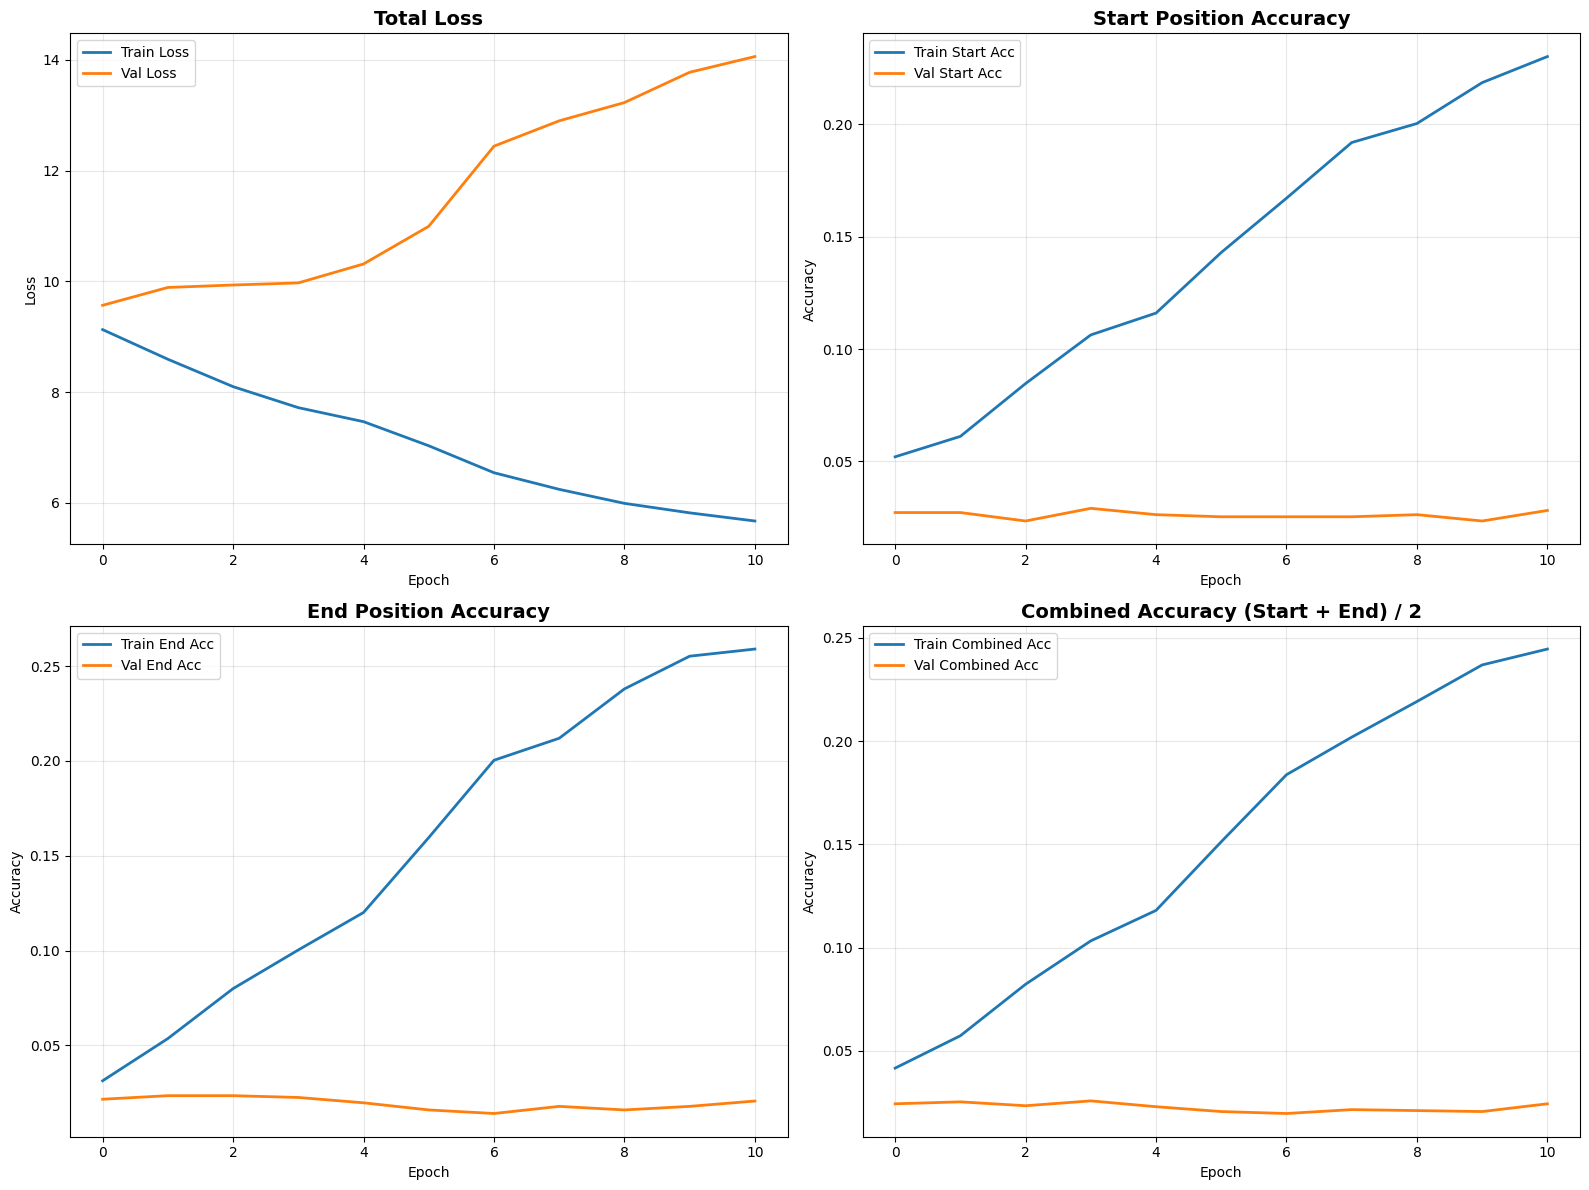

Training history plot saved to Output Model LSTM/training_history.png


In [20]:
# Visualisasi training history untuk melihat performa model selama training
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # bikin 4 subplot dalam grid 2x2

# Plot 1: Total Loss (training vs validation)
axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)  # plot training loss
axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)  # plot validation loss
axes[0, 0].set_title('Total Loss', fontsize=14, fontweight='bold')  # judul grafik
axes[0, 0].set_xlabel('Epoch')  # label sumbu x
axes[0, 0].set_ylabel('Loss')  # label sumbu y
axes[0, 0].legend()  # tampilkan legend
axes[0, 0].grid(True, alpha=0.3)  # tambahkan grid dengan transparansi

# Plot 2: Start Position Accuracy
axes[0, 1].plot(history.history['start_output_accuracy'], label='Train Start Acc', linewidth=2)  # accuracy training untuk start
axes[0, 1].plot(history.history['val_start_output_accuracy'], label='Val Start Acc', linewidth=2)  # accuracy validation untuk start
axes[0, 1].set_title('Start Position Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: End Position Accuracy
axes[1, 0].plot(history.history['end_output_accuracy'], label='Train End Acc', linewidth=2)  # accuracy training untuk end
axes[1, 0].plot(history.history['val_end_output_accuracy'], label='Val End Acc', linewidth=2)  # accuracy validation untuk end
axes[1, 0].set_title('End Position Accuracy', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Combined Accuracy (rata-rata start dan end)
# Hitung rata-rata accuracy start dan end untuk setiap epoch
train_combined = [(history.history['start_output_accuracy'][i] + history.history['end_output_accuracy'][i]) / 2
                  for i in range(len(history.history['start_output_accuracy']))]  # list comprehension
val_combined = [(history.history['val_start_output_accuracy'][i] + history.history['val_end_output_accuracy'][i]) / 2
                for i in range(len(history.history['val_start_output_accuracy']))]

axes[1, 1].plot(train_combined, label='Train Combined Acc', linewidth=2)  # plot combined training accuracy
axes[1, 1].plot(val_combined, label='Val Combined Acc', linewidth=2)  # plot combined validation accuracy
axes[1, 1].set_title('Combined Accuracy (Start + End) / 2', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()  # atur layout supaya tidak overlap
plt.savefig(output_dir + 'training_history.png', dpi=300, bbox_inches='tight')  # save grafik ke file PNG dengan resolusi tinggi
plt.show()  # tampilkan grafik

print(f"Training history plot saved to {output_dir}training_history.png")

## 9. Save Model and Config

Menyimpan model, tokenizer, dan konfigurasi untuk inference nanti.

In [ ]:
# Save model final ke file
model.save(output_dir + 'final_lstm_model.h5')  # save model dalam format HDF5
print(f"Final model saved to {output_dir}final_lstm_model.h5")

# Save konfigurasi model dalam dictionary
config = {
    'vocab_size': vocab_size,  # ukuran vocabulary
    'max_context_len': MAX_CONTEXT_LEN,  # panjang maksimal context
    'max_question_len': MAX_QUESTION_LEN,  # panjang maksimal question
    'embedding_dim': EMBEDDING_DIM,  # dimensi embedding
    'lstm_units': RNN_UNITS,  # jumlah LSTM units
    'max_vocab_size': MAX_VOCAB_SIZE  # maksimal vocab size yang digunakan
}

# Simpan config ke file pickle
with open(output_dir + 'config.pickle', 'wb') as f:  # buka file dalam mode write binary
    pickle.dump(config, f)  # dump dictionary config ke file

print(f"Configuration saved to {output_dir}config.pickle")

# Save training history untuk analisis nanti
with open(output_dir + 'history.pickle', 'wb') as f:
    pickle.dump(history.history, f)  # dump history dictionary (berisi loss dan metrics per epoch)

print(f"Training history saved to {output_dir}history.pickle")
print("\nAll artifacts saved successfully!")

Final model saved to ../Output Model RNN/final_rnn_model.h5
Configuration saved to ../Output Model RNN/config.pickle
Training history saved to ../Output Model RNN/history.pickle

All artifacts saved successfully!


## 10. Model Evaluation

Evaluasi performa model pada validation set.

In [21]:
# Evaluasi performa model pada validation set
print("Evaluating model on validation set...")
# evaluate() menjalankan forward pass tanpa update weights
results = model.evaluate(
    [X_context_val, X_question_val],  # input validation
    [y_start_val_cat, y_end_val_cat],  # target validation
    batch_size=BATCH_SIZE,  # ukuran batch untuk evaluasi
    verbose=1  # print progress bar
)

# Tampilkan hasil evaluasi dengan format yang rapi
print("\n" + "="*50)
print("VALIDATION RESULTS")
print("="*50)
print(f"Total Loss: {results[0]:.4f}")  # total loss (start + end)
print(f"Start Loss: {results[1]:.4f}")  # loss untuk prediksi start position
print(f"End Loss: {results[2]:.4f}")  # loss untuk prediksi end position
print(f"Start Accuracy: {results[3]:.4f} ({results[3]*100:.2f}%)")  # accuracy start position dalam persen
print(f"End Accuracy: {results[4]:.4f} ({results[4]*100:.2f}%)")  # accuracy end position dalam persen
print(f"Combined Accuracy: {(results[3] + results[4])/2:.4f} ({(results[3] + results[4])/2*100:.2f}%)")  # rata-rata accuracy
print("="*50)

Evaluating model on validation set...
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - end_output_accuracy: 0.0214 - end_output_loss: 4.9709 - loss: 9.7483 - start_output_accuracy: 0.0262 - start_output_loss: 4.7790

VALIDATION RESULTS
Total Loss: 9.8015
Start Loss: 4.8312
End Loss: 4.9842
Start Accuracy: 0.0244 (2.44%)
End Accuracy: 0.0226 (2.26%)
Combined Accuracy: 0.0235 (2.35%)


## 11. Inference Function

Fungsi untuk menjawab pertanyaan berdasarkan context yang diberikan.

In [22]:
def predict_answer(model, tokenizer, context, question, max_context_len, max_question_len):
    """
    Fungsi untuk prediksi jawaban dari pertanyaan berdasarkan context yang diberikan.

    Args:
        model: model LSTM yang sudah di-train
        tokenizer: tokenizer untuk convert text jadi sequence
        context: teks context yang berisi informasi
        question: pertanyaan yang ingin dijawab
        max_context_len: panjang maksimal context
        max_question_len: panjang maksimal question

    Returns:
        answer: jawaban yang diprediksi (string)
        start_idx: index posisi start answer
        end_idx: index posisi end answer
        start_prob: confidence score untuk start position
        end_prob: confidence score untuk end position
    """
    # Bersihkan teks dulu
    context_clean = clean_text(context)  # clean context
    question_clean = clean_text(question)  # clean question

    # Tokenize: convert text jadi sequences of integers
    context_seq = tokenizer.texts_to_sequences([context_clean])  # context jadi list of integers
    question_seq = tokenizer.texts_to_sequences([question_clean])  # question jadi list of integers

    # Padding: bikin semua sequences sama panjang
    context_padded = pad_sequences(context_seq, maxlen=max_context_len, padding='post', truncating='post')
    question_padded = pad_sequences(question_seq, maxlen=max_question_len, padding='post', truncating='post')

    # Prediksi menggunakan model (forward pass melalui LSTM)
    start_probs, end_probs = model.predict([context_padded, question_padded], verbose=0)  # verbose=0 supaya tidak print

    # Ambil index dengan probability tertinggi
    start_idx = np.argmax(start_probs[0])  # argmax untuk ambil index probability tertinggi
    end_idx = np.argmax(end_probs[0])

    # Pastikan end_idx >= start_idx (logika answer harus start dulu baru end)
    if end_idx < start_idx:
        end_idx = start_idx  # set end sama dengan start kalau tidak masuk akal

    # Extract answer dari context berdasarkan index yang diprediksi
    context_words = context_clean.split()  # split context jadi list kata

    # Validasi index tidak out of bounds
    if start_idx < len(context_words) and end_idx < len(context_words):
        answer = ' '.join(context_words[start_idx:end_idx+1])  # ambil kata dari start sampai end (inclusive)
    else:
        answer = "Tidak dapat menemukan jawaban"  # default answer kalau index invalid

    # Get confidence scores (probability values)
    start_prob = float(start_probs[0][start_idx])  # convert numpy float ke python float
    end_prob = float(end_probs[0][end_idx])

    return answer, start_idx, end_idx, start_prob, end_prob  # return semua informasi

print("Fungsi predict_answer() telah siap!")
print("Fungsi ini akan digunakan untuk inference/prediksi.")

Fungsi predict_answer() telah siap!
Fungsi ini akan digunakan untuk inference/prediksi.


## 12. Test Chatbot - Interactive QA

Test model dengan beberapa contoh dari validation set.

In [23]:
# Test chatbot dengan beberapa contoh random dari validation set
num_examples = 5  # jumlah contoh yang mau di-test
test_indices = np.random.choice(len(val_filtered), num_examples, replace=False)  # random sampling tanpa replacement

print("CHATBOT QUESTION-ANSWERING - DEMO")
print("="*80)

# Loop untuk setiap contoh yang dipilih
for i, idx in enumerate(test_indices, 1):  # enumerate dimulai dari 1
    example = val_filtered[idx]  # ambil data dari validation set

    # Extract context, question, dan true answer
    context = example['context']
    question = example['question']
    true_answer = example['answer']

    # Prediksi jawaban menggunakan model
    pred_answer, start_idx, end_idx, start_conf, end_conf = predict_answer(
        model, tokenizer, context, question, MAX_CONTEXT_LEN, MAX_QUESTION_LEN
    )

    # Tampilkan hasil prediksi dengan format yang rapi
    print(f"\n{'='*80}")
    print(f"CONTOH {i}")
    print(f"{'='*80}")
    print(f"\nCONTEXT:")
    print(f"{context[:300]}..." if len(context) > 300 else context)  # potong kalau terlalu panjang
    print(f"\nQUESTION: {question}")
    print(f"\nTRUE ANSWER: {true_answer}")  # jawaban yang sebenarnya
    print(f"\nPREDICTED ANSWER: {pred_answer}")  # jawaban hasil prediksi model
    print(f"\nConfidence: Start={start_conf:.4f}, End={end_conf:.4f}")  # confidence score
    print(f"Position: [{start_idx}, {end_idx}]")  # posisi start dan end dalam kata

    # Cek apakah jawaban benar (partial match)
    if pred_answer.lower().strip() in true_answer.lower().strip() or true_answer.lower().strip() in pred_answer.lower().strip():
        print("\nSTATUS: BENAR!")  # kalau ada overlap antara predicted dan true answer
    else:
        print("\nSTATUS: Tidak tepat")  # kalau tidak match

print(f"\n{'='*80}")

CHATBOT QUESTION-ANSWERING - DEMO

CONTOH 1

CONTEXT:
Menghadapi tuntutan untuk mundur, pada 1 Mei 1998, Soeharto menyatakan bahwa reformasi akan dipersiapkan mulai tahun 2003. Ketika di Mesir pada 13 Mei 1998, Presiden Soeharto menyatakan bersedia mundur kalau memang rakyat menghendaki dan tidak akan mempertahankan kedudukannya dengan kekuatan senjata...

QUESTION: Berapa banyak mentri yang mengundurkan diri?

TRUE ANSWER: Sebelas menteri bidang ekonomi dan industri

PREDICTED ANSWER: 1

Confidence: Start=0.1292, End=0.0788
Position: [5, 5]

STATUS: Tidak tepat

CONTOH 2

CONTEXT:
Kebebasan pers di Indonesia meningkat setelah berakhirnya kekuasaan Presiden Soeharto. Jaringan televisi publik TVRI bersaing dengan jaringan televisi swasta nasional dan stasiun daerah; begitu pula dengan jaringan radio publik RRI yang bersaing dengan jaringan radio swasta yang menyiarkan berita da...

QUESTION: Apa dampak positif dari turunnya Presiden Soeharto dari jabatannya?

TRUE ANSWER: Kebebasan pers

## 13. Custom Question Testing

Coba chatbot dengan pertanyaan custom Anda sendiri!

In [25]:
# Fungsi untuk testing dengan custom context dan question
def test_custom_qa(context, question):
    """
    Test chatbot dengan custom context dan question yang kita tentukan sendiri.

    Args:
        context: teks paragraf yang berisi informasi
        question: pertanyaan yang ingin dijawab

    Returns:
        pred_answer: jawaban yang diprediksi oleh model
    """
    print("\n" + "="*80)
    print("CHATBOT QA - CUSTOM TEST")
    print("="*80)

    # Prediksi jawaban menggunakan fungsi predict_answer
    pred_answer, start_idx, end_idx, start_conf, end_conf = predict_answer(
        model, tokenizer, context, question, MAX_CONTEXT_LEN, MAX_QUESTION_LEN
    )

    # Tampilkan hasil dengan format yang rapi
    print(f"\nCONTEXT:")
    print(context)  # tampilkan full context
    print(f"\nQUESTION: {question}")
    print(f"\nJAWABAN: {pred_answer}")  # jawaban hasil prediksi
    print(f"\nConfidence: Start={start_conf:.4f}, End={end_conf:.4f}")  # confidence score model
    print(f"Position: [{start_idx}, {end_idx}]")  # posisi kata dalam context
    print("="*80)

    return pred_answer  # return jawaban untuk digunakan lagi kalau perlu

# Contoh penggunaan 1: pertanyaan tentang kemerdekaan Indonesia
custom_context = """Soekarno dan Mohammad Hatta memproklamasikan kemerdekaan Indonesia
pada tanggal 17 Agustus 1945 di Jakarta. Peristiwa bersejarah ini menandai lahirnya
Republik Indonesia sebagai negara merdeka."""

custom_question = "Kapan Indonesia merdeka?"

# Test dengan pertanyaan pertama
answer = test_custom_qa(custom_context, custom_question)

# Contoh penggunaan 2: pertanyaan tentang proklamator
custom_question2 = "Siapa yang memproklamasikan kemerdekaan Indonesia?"
# Test dengan pertanyaan kedua menggunakan context yang sama
answer2 = test_custom_qa(custom_context, custom_question2)


CHATBOT QA - CUSTOM TEST

CONTEXT:
Soekarno dan Mohammad Hatta memproklamasikan kemerdekaan Indonesia
pada tanggal 17 Agustus 1945 di Jakarta. Peristiwa bersejarah ini menandai lahirnya
Republik Indonesia sebagai negara merdeka.

QUESTION: Kapan Indonesia merdeka?

JAWABAN: tanggal 17

Confidence: Start=0.1285, End=0.0819
Position: [8, 9]

CHATBOT QA - CUSTOM TEST

CONTEXT:
Soekarno dan Mohammad Hatta memproklamasikan kemerdekaan Indonesia
pada tanggal 17 Agustus 1945 di Jakarta. Peristiwa bersejarah ini menandai lahirnya
Republik Indonesia sebagai negara merdeka.

QUESTION: Siapa yang memproklamasikan kemerdekaan Indonesia?

JAWABAN: tanggal 17

Confidence: Start=0.0845, End=0.0494
Position: [8, 9]


## 14. Interactive Chatbot - Input Manual

Gunakan chatbot secara interaktif! Masukkan context dan question Anda sendiri.

In [ ]:
def interactive_chatbot():
    """
    Fungsi chatbot interaktif yang menerima input context dan question langsung dari user.
    User bisa bertanya berkali-kali sampai memilih untuk keluar.
    """
    # Tampilkan header dan instruksi penggunaan
    print("="*80)
    print("CHATBOT QA INTERAKTIF - BAHASA INDONESIA")
    print("="*80)
    print("\nTips:")
    print("  - Masukkan context (paragraf yang berisi informasi)")
    print("  - Masukkan question (pertanyaan tentang context)")
    print("  - Ketik 'exit' atau 'quit' untuk keluar")
    print("  - Ketik 'contoh' untuk melihat contoh")
    print("="*80)

    # Loop utama chatbot - akan terus berjalan sampai user keluar
    while True:
        print("\n" + "─"*80)

        # Input context dari user (bisa multi-line)
        print("\nMasukkan CONTEXT (paragraf/teks):")
        print("(Tekan Enter 2x untuk selesai, atau ketik 'exit' untuk keluar)")

        context_lines = []  # list untuk tampung baris-baris context
        while True:  # inner loop untuk input multi-line
            line = input()  # baca satu baris
            if line.lower() in ['exit', 'quit']:  # cek kalau user mau keluar
                print("\nTerima kasih telah menggunakan chatbot!")
                return  # keluar dari fungsi
            elif line.lower() == 'contoh':  # kalau user mau lihat contoh
                show_examples()  # panggil fungsi show_examples
                break  # keluar dari inner loop
            elif line == '' and len(context_lines) > 0:  # kalau enter kosong dan sudah ada input
                break  # selesai input context
            elif line != '':  # kalau line tidak kosong
                context_lines.append(line)  # tambahkan ke list

        if line.lower() == 'contoh':  # kalau tadi pilih contoh
            continue  # mulai dari awal loop

        context = ' '.join(context_lines)  # gabungkan semua baris jadi satu string

        # Validasi context tidak kosong
        if not context.strip():
            print("Context tidak boleh kosong!")
            continue  # kembali ke awal loop

        # Input question dari user (single line)
        print("\nMasukkan QUESTION (pertanyaan):")
        question = input().strip()  # baca question dan trim whitespace

        # Cek kalau user mau keluar
        if question.lower() in ['exit', 'quit']:
            print("\nTerima kasih telah menggunakan chatbot!")
            return

        # Validasi question tidak kosong
        if not question:
            print("Question tidak boleh kosong!")
            continue

        # Tampilkan status processing
        print("\n" + "="*80)
        print("MEMPROSES...")
        print("="*80)

        # Try-except untuk handle error saat prediksi
        try:
            # Prediksi jawaban menggunakan model
            pred_answer, start_idx, end_idx, start_conf, end_conf = predict_answer(
                model, tokenizer, context, question, MAX_CONTEXT_LEN, MAX_QUESTION_LEN
            )

            # Tampilkan hasil prediksi dengan format yang rapi
            print(f"\nCONTEXT:")
            print(f"{context}")
            print(f"\nQUESTION: {question}")
            print(f"\nJAWABAN: {pred_answer}")
            print(f"\nConfidence Score:")
            print(f"   Start Position: {start_conf:.4f} ({start_conf*100:.2f}%)")  # confidence untuk start
            print(f"   End Position: {end_conf:.4f} ({end_conf*100:.2f}%)")  # confidence untuk end
            print(f"   Average: {(start_conf + end_conf)/2:.4f} ({(start_conf + end_conf)/2*100:.2f}%)")  # rata-rata
            print(f"\nPosition in Context: Word {start_idx} to {end_idx}")

            # Interpretasi confidence score untuk user
            avg_conf = (start_conf + end_conf) / 2  # hitung rata-rata confidence
            if avg_conf > 0.7:  # kalau confidence tinggi
                print("\nConfidence: TINGGI - Jawaban kemungkinan besar benar!")
            elif avg_conf > 0.4:  # kalau confidence sedang
                print("\nConfidence: SEDANG - Jawaban mungkin benar, periksa kembali")
            else:  # kalau confidence rendah
                print("\nConfidence: RENDAH - Jawaban mungkin tidak akurat")

        except Exception as e:  # kalau ada error
            print(f"\nError: {str(e)}")
            print("Silakan coba lagi dengan context/question yang berbeda.")

        # Tanya user apakah mau lanjut atau keluar
        print("\n" + "="*80)
        print("\nIngin bertanya lagi? (Y/N)")
        continue_choice = input().strip().lower()  # baca pilihan user
        if continue_choice in ['n', 'no', 'tidak', 'exit', 'quit']:  # kalau tidak mau lanjut
            print("\nTerima kasih telah menggunakan chatbot!")
            break  # keluar dari loop utama

def show_examples():
    """
    Fungsi helper untuk menampilkan contoh-contoh penggunaan chatbot.
    """
    print("\n" + "="*80)
    print("CONTOH-CONTOH PENGGUNAAN")
    print("="*80)

    # List contoh context dan questions
    examples = [
        {
            "context": "Proklamasi kemerdekaan Indonesia dibacakan oleh Soekarno pada tanggal 17 Agustus 1945 di Jalan Pegangsaan Timur 56, Jakarta. Peristiwa ini disaksikan oleh ratusan orang dan menandai lahirnya negara Indonesia yang merdeka.",
            "questions": [
                "Kapan Indonesia merdeka?",
                "Siapa yang membacakan proklamasi?",
                "Di mana proklamasi dibacakan?"
            ]
        },
        {
            "context": "Candi Borobudur merupakan candi Buddha terbesar di dunia yang terletak di Magelang, Jawa Tengah. Candi ini dibangun pada abad ke-8 dan ke-9 pada masa pemerintahan wangsa Syailendra. Borobudur memiliki 504 arca Buddha dan 2.672 panel relief.",
            "questions": [
                "Di mana letak Candi Borobudur?",
                "Kapan Candi Borobudur dibangun?",
                "Berapa jumlah arca Buddha di Borobudur?"
            ]
        },
        {
            "context": "Sumpah Pemuda dibacakan pada tanggal 28 Oktober 1928 di Jakarta. Isi sumpah pemuda adalah bertanah air satu Indonesia, berbangsa satu Indonesia, dan menjunjung bahasa persatuan bahasa Indonesia. Peristiwa ini menjadi tonggak penting persatuan Indonesia.",
            "questions": [
                "Kapan Sumpah Pemuda dibacakan?",
                "Apa isi Sumpah Pemuda?",
                "Di mana Sumpah Pemuda dibacakan?"
            ]
        }
    ]

    # Loop untuk tampilkan setiap contoh
    for i, example in enumerate(examples, 1):  # enumerate dimulai dari 1
        print(f"\n{'─'*80}")
        print(f"CONTOH {i}:")
        print(f"{'─'*80}")
        print(f"\nContext:")
        print(f"{example['context']}")
        print(f"\nContoh Questions:")
        for j, q in enumerate(example['questions'], 1):  # loop questions dengan numbering
            print(f"   {j}. {q}")

    print(f"\n{'='*80}")
    print("Silakan copy-paste contoh di atas atau buat sendiri!")
    print(f"{'='*80}\n")

# Tampilkan informasi cara penggunaan
print("Fungsi interactive_chatbot() telah siap!")
print("\nCara menggunakan:")
print("   1. Jalankan: interactive_chatbot()")
print("   2. Masukkan context (paragraf)")
print("   3. Tekan Enter 2x untuk selesai input context")
print("   4. Masukkan question")
print("   5. Lihat jawaban dari chatbot!")
print("\nSIAP DIGUNAKAN! Jalankan cell berikutnya untuk mulai!")

Fungsi interactive_chatbot() telah siap!

Cara menggunakan:
   1. Jalankan: interactive_chatbot()
   2. Masukkan context (paragraf)
   3. Tekan Enter 2x untuk selesai input context
   4. Masukkan question
   5. Lihat jawaban dari chatbot!

SIAP DIGUNAKAN! Jalankan cell berikutnya untuk mulai!


### Jalankan Chatbot Interaktif

Jalankan cell di bawah ini untuk memulai chatbot interaktif!

In [ ]:
# JALANKAN CELL INI UNTUK MEMULAI CHATBOT INTERAKTIF
# Cell ini akan memanggil fungsi interactive_chatbot() yang sudah didefinisikan di atas
interactive_chatbot()  # panggil fungsi untuk mulai sesi chatbot interaktif

CHATBOT QA INTERAKTIF - BAHASA INDONESIA

Tips:
  - Masukkan context (paragraf yang berisi informasi)
  - Masukkan question (pertanyaan tentang context)
  - Ketik 'exit' atau 'quit' untuk keluar
  - Ketik 'contoh' untuk melihat contoh

────────────────────────────────────────────────────────────────────────────────

Masukkan CONTEXT (paragraf/teks):
(Tekan Enter 2x untuk selesai, atau ketik 'exit' untuk keluar)

Masukkan QUESTION (pertanyaan):

Masukkan QUESTION (pertanyaan):

MEMPROSES...

CONTEXT:
Pada tanggal 17 Agustus 1945, Indonesia memproklamasikan kemerdekaannya setelah berabad-abad dijajah oleh bangsa asing, terutama Belanda dan Jepang. Proklamasi kemerdekaan dibacakan oleh Soekarno dan Hatta di Jalan Pegangsaan Timur No. 56, Jakarta. Setelah proklamasi, dibentuk Komite Nasional Indonesia Pusat (KNIP) sebagai lembaga sementara yang membantu tugas presiden. Pada 18 Agustus 1945, Panitia Persiapan Kemerdekaan Indonesia (PPKI) mengesahkan Undang-Undang Dasar 1945 dan menetapkan S

### Alternatif: Quick Test (Tanpa Loop)

Jika Anda ingin test cepat tanpa loop interaktif, gunakan cell di bawah ini:

In [ ]:
# ============================================================================
# QUICK TEST - GANTI CONTEXT DAN QUESTION DI SINI
# ============================================================================

# MASUKKAN CONTEXT ANDA DI SINI (paragraf yang berisi informasi):
my_context = """
Soekarno dan Mohammad Hatta memproklamasikan kemerdekaan Indonesia
pada tanggal 17 Agustus 1945 di Jalan Pegangsaan Timur 56, Jakarta.
Peristiwa bersejarah ini disaksikan oleh ratusan rakyat Indonesia
dan menandai lahirnya Republik Indonesia sebagai negara merdeka.
"""

# MASUKKAN QUESTION ANDA DI SINI (pertanyaan tentang context):
my_question = "Siapa yang memproklamasikan kemerdekaan Indonesia?"

# ============================================================================
# JANGAN EDIT KODE DI BAWAH INI - LANGSUNG JALANKAN!
# ============================================================================

# Tampilkan header mode quick test
print("="*80)
print("CHATBOT QA - QUICK TEST MODE")
print("="*80)

# Prediksi jawaban menggunakan context dan question yang sudah ditentukan
pred_answer, start_idx, end_idx, start_conf, end_conf = predict_answer(
    model, tokenizer, my_context, my_question, MAX_CONTEXT_LEN, MAX_QUESTION_LEN
)

# Tampilkan hasil dengan format yang rapi
print(f"\nCONTEXT:")
print(my_context.strip())  # strip untuk hapus whitespace di awal dan akhir
print(f"\nQUESTION:")
print(my_question)
print(f"\nJAWABAN:")
print(f"   {pred_answer}")
print(f"\nCONFIDENCE SCORE:")
print(f"   Start Position: {start_conf:.4f} ({start_conf*100:.2f}%)")  # confidence score untuk start position
print(f"   End Position: {end_conf:.4f} ({end_conf*100:.2f}%)")  # confidence score untuk end position
print(f"   Average: {(start_conf + end_conf)/2:.4f} ({(start_conf + end_conf)/2*100:.2f}%)")  # rata-rata confidence
print(f"\nPOSITION:")
print(f"   Word {start_idx} to {end_idx}")  # posisi kata di context

# Interpretasi confidence score untuk user
avg_conf = (start_conf + end_conf) / 2  # hitung rata-rata confidence
print(f"\nINTERPRETASI:")
if avg_conf > 0.7:  # kalau confidence tinggi (lebih dari 70%)
    print("   TINGGI - Jawaban kemungkinan besar benar!")
elif avg_conf > 0.4:  # kalau confidence sedang (40-70%)
    print("   SEDANG - Jawaban mungkin benar, periksa kembali")
else:  # kalau confidence rendah (kurang dari 40%)
    print("   RENDAH - Jawaban mungkin tidak akurat")

print("\n" + "="*80)
print("TIP: Edit variabel 'my_context' dan 'my_question' di atas,")
print("        lalu jalankan ulang cell ini untuk test dengan data baru!")
print("="*80)

CHATBOT QA - QUICK TEST MODE

CONTEXT:
Soekarno dan Mohammad Hatta memproklamasikan kemerdekaan Indonesia 
pada tanggal 17 Agustus 1945 di Jalan Pegangsaan Timur 56, Jakarta. 
Peristiwa bersejarah ini disaksikan oleh ratusan rakyat Indonesia 
dan menandai lahirnya Republik Indonesia sebagai negara merdeka.

QUESTION:
Siapa yang memproklamasikan kemerdekaan Indonesia?

JAWABAN:
   tanggal 17 agustus 1945

CONFIDENCE SCORE:
   Start Position: 0.1015 (10.15%)
   End Position: 0.1300 (13.00%)
   Average: 0.1157 (11.57%)

POSITION:
   Word 8 to 11

INTERPRETASI:
   RENDAH - Jawaban mungkin tidak akurat

TIP: Edit variabel 'my_context' dan 'my_question' di atas,
        lalu jalankan ulang cell ini untuk test dengan data baru!


## 15. Model Analysis & Insights

Analisis performa dan karakteristik model.

In [ ]:
# Hitung Exact Match dan F1 scores untuk evaluasi performa model
from collections import Counter  # import Counter untuk hitung overlap kata

def calculate_f1(pred_answer, true_answer):
    """
    Fungsi untuk menghitung F1 score antara predicted answer dan true answer.
    F1 score mengukur kesamaan antara dua set kata (precision dan recall).

    Args:
        pred_answer: jawaban hasil prediksi model
        true_answer: jawaban yang sebenarnya

    Returns:
        f1: F1 score (0.0 - 1.0)
    """
    # Tokenize dan lowercase kedua jawaban
    pred_tokens = pred_answer.lower().split()  # split jawaban prediksi jadi list kata
    true_tokens = true_answer.lower().split()  # split jawaban true jadi list kata

    # Kalau salah satu kosong, F1 score = 0
    if len(pred_tokens) == 0 or len(true_tokens) == 0:
        return 0

    # Hitung kata yang sama antara pred dan true (intersection)
    common = Counter(pred_tokens) & Counter(true_tokens)  # intersection menggunakan & operator
    num_same = sum(common.values())  # jumlah kata yang sama

    # Kalau tidak ada kata yang sama, F1 = 0
    if num_same == 0:
        return 0

    # Hitung precision dan recall
    precision = num_same / len(pred_tokens)  # precision = kata sama / total kata prediksi
    recall = num_same / len(true_tokens)  # recall = kata sama / total kata true
    f1 = 2 * precision * recall / (precision + recall)  # F1 = harmonic mean dari precision dan recall

    return f1

# Evaluasi pada sample dari validation set
sample_size = min(100, len(val_filtered))  # ambil maksimal 100 sample (atau semua kalau kurang)
exact_matches = 0  # counter untuk exact match
f1_scores = []  # list untuk tampung F1 scores

print("Calculating Exact Match and F1 scores...")
# Loop semua sample untuk evaluasi
for i in tqdm(range(sample_size)):  # tqdm untuk progress bar
    example = val_filtered[i]  # ambil contoh dari validation set
    context = example['context']
    question = example['question']
    true_answer = example['answer']

    # Prediksi jawaban menggunakan model
    pred_answer, _, _, _, _ = predict_answer(
        model, tokenizer, context, question, MAX_CONTEXT_LEN, MAX_QUESTION_LEN
    )

    # Cek exact match (jawaban 100% sama)
    if pred_answer.lower().strip() == true_answer.lower().strip():
        exact_matches += 1  # increment counter kalau exact match

    # Hitung F1 score (partial match)
    f1 = calculate_f1(pred_answer, true_answer)
    f1_scores.append(f1)  # tambahkan ke list

# Hitung metrics akhir
exact_match_score = exact_matches / sample_size * 100  # exact match dalam persen
avg_f1_score = np.mean(f1_scores) * 100  # rata-rata F1 score dalam persen

# Tampilkan hasil evaluasi
print("\n" + "="*50)
print("MODEL PERFORMANCE METRICS")
print("="*50)
print(f"Sample Size: {sample_size}")  # jumlah sample yang dievaluasi
print(f"Exact Match (EM): {exact_match_score:.2f}%")  # persentase exact match
print(f"Average F1 Score: {avg_f1_score:.2f}%")  # rata-rata F1 score
print("="*50)

Calculating Exact Match and F1 scores...


100%|██████████| 100/100 [00:07<00:00, 14.27it/s]


MODEL PERFORMANCE METRICS
Sample Size: 100
Exact Match (EM): 1.00%
Average F1 Score: 6.48%
